<a href="https://colab.research.google.com/github/aritrasen87/LLM_From_Scratch/blob/main/3_LLM_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In Depth Theory Content : https://youtu.be/10OlBEYlh6A

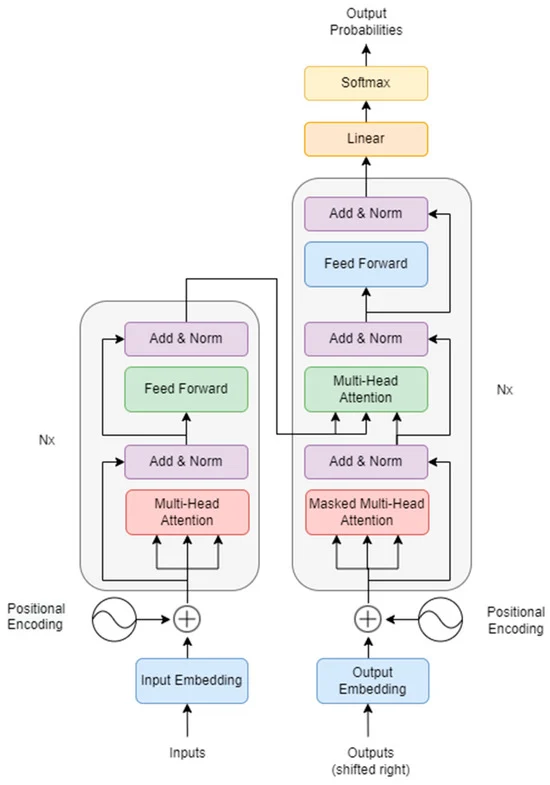

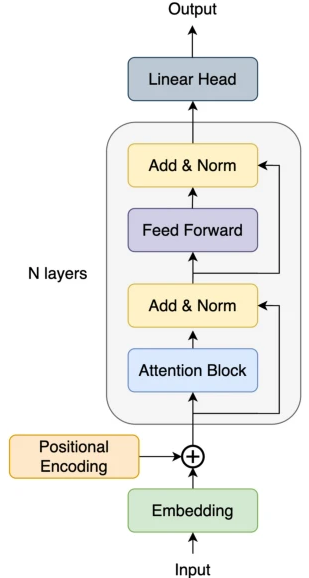

1. Text -> Tokens
2. Input embeddings
3. Positional Encoding
4. Masked Multihead Attention
5. Feedforward
5. Add & Norm

# 1. Text -> Token

In [2]:
! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-10-23 05:03:35--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.006s  

2024-10-23 05:03:35 (178 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
! pip install tiktoken --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.8 MB/s eta 0:00:00


In [5]:
### Adopted from Andrej Karpathy's Code

import tiktoken

class GetBatches:
    def __init__(self , B , T) -> None:
        self.B = B # batch size
        self.T = T # time_dim or context length or block_size

        with open("input.txt", "r") as f:
            raw_text = f.read()

        tokenizer = tiktoken.get_encoding("gpt2")
        tokens = tokenizer.encode(raw_text)

        self.tokens = torch.tensor(tokens)

        print(f'Length of tokens : {len(self.tokens)}')
        print(f'One Epoch has : {len(self.tokens) // (B * T) } batches')

        self.current_position = 0

    def get_batch(self):

        buff = self.tokens[self.current_position : self.current_position + self.B*self.T+1]
        x = buff[:-1].view(self.B,self.T)
        y = buff[1:].view(self.B,self.T)

        self.current_position += self.B * self.T

        if self.current_position + (self.B * self.T + 1) > len(self.tokens):
            self.current_position = 0

        x = x.to(device)
        y = y.to(device)

        return x , y



# 2. Input Embedding & 3. Positional Encoding

In [6]:
tokenizer = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer.n_vocab
print(f'Vocab Size : {vocab_size}')

n_embd = 384

print(f'Embedding dimension : {n_embd}')

block_size = 512 # max sequnce length

print(f'Max Sequence length : {block_size}')

Vocab Size : 50257
Embedding dimension : 384
Max Sequence length : 512


In [12]:
### Look up tables for embedding + positional encoding

import torch.nn as nn
token_embedding_table = nn.Embedding(vocab_size, n_embd).to(device)
position_embedding_table = nn.Embedding(block_size, n_embd).to(device)

In [13]:
dataloader = GetBatches(B=4,T=block_size)
x , y = dataloader.get_batch()

print(f'\n Input data: \n {x}')

print(f'\n Target data: \n {y}')

Length of tokens : 338025
One Epoch has : 165 batches

 Input data: 
 tensor([[ 5962, 22307,    25,  ...,    11,   351, 18201],
        [   11,   284, 15867,  ...,  1842,   484,  6842],
        [  514,    13,   198,  ...,   345,   198,  1532],
        [  345,  1183,  1266,  ...,   275,  1000,    13]], device='cuda:0')

 Target data: 
 tensor([[22307,    25,   198,  ...,   351, 18201,    11],
        [  284, 15867,   287,  ...,   484,  6842,   514],
        [   13,   198,   198,  ...,   198,  1532,   345],
        [ 1183,  1266,   322,  ...,  1000,    13,   198]], device='cuda:0')


In [14]:
x.shape

torch.Size([4, 512])

In [15]:
B , T = x.shape
B , T

(4, 512)

In [16]:
tok_embdding = token_embedding_table(x)
tok_embdding.shape # (B , T , D)

torch.Size([4, 512, 384])

In [17]:
pos_emb = position_embedding_table(torch.arange(T,device=device))
pos_emb.shape # (T , D)

torch.Size([512, 384])

In [18]:
x = tok_embdding + pos_emb
x.shape # (B , T , D)

torch.Size([4, 512, 384])

# 4. Masked Multihead attention

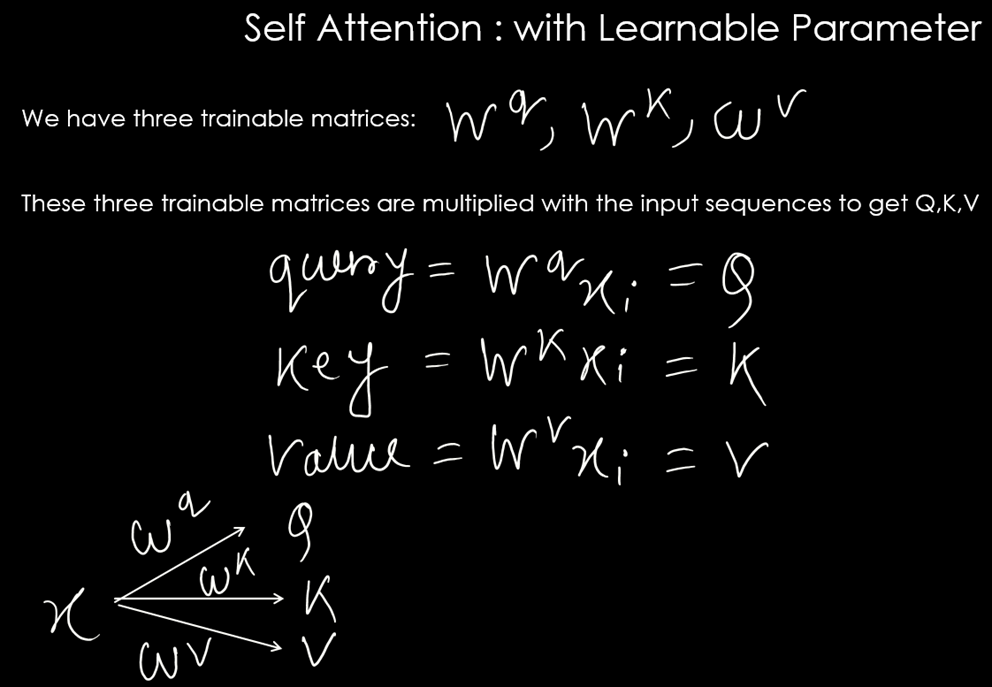

In [19]:
x.shape # x

torch.Size([4, 512, 384])

In [21]:
head_size = 256
w_query = nn.Linear(n_embd , head_size , bias=False,device=device)
w_key = nn.Linear(n_embd , head_size , bias=False,device=device)
w_value = nn.Linear(n_embd , head_size, bias=False,device=device)

q = w_query(x)
k = w_key(x)
v = w_value(x)

print(f'Q shape: {q.shape}') # (B , T , head_size)
print(f'K shape: {k.shape}') # (B , T , head_size)
print(f'V shape: {v.shape}') # (B , T , head_size)

Q shape: torch.Size([4, 512, 256])
K shape: torch.Size([4, 512, 256])
V shape: torch.Size([4, 512, 256])


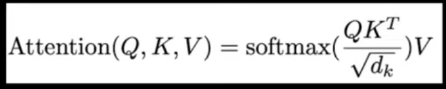

In [22]:
# Dk
k.shape[-1]

256

In [23]:
# K Transpose
k.shape , k.transpose(-2 , -1).shape

(torch.Size([4, 512, 256]), torch.Size([4, 256, 512]))

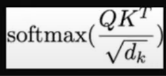

In [24]:
wei = q @ k.transpose(-2 , -1) * k.shape[-1]**-0.5 # (B , T , head_size ) @ (B , head_size , T) --> (B,T,T)
wei.shape

torch.Size([4, 512, 512])

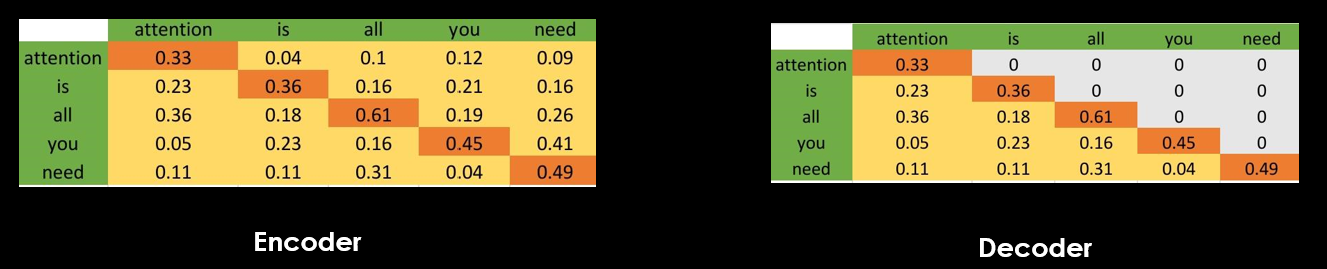

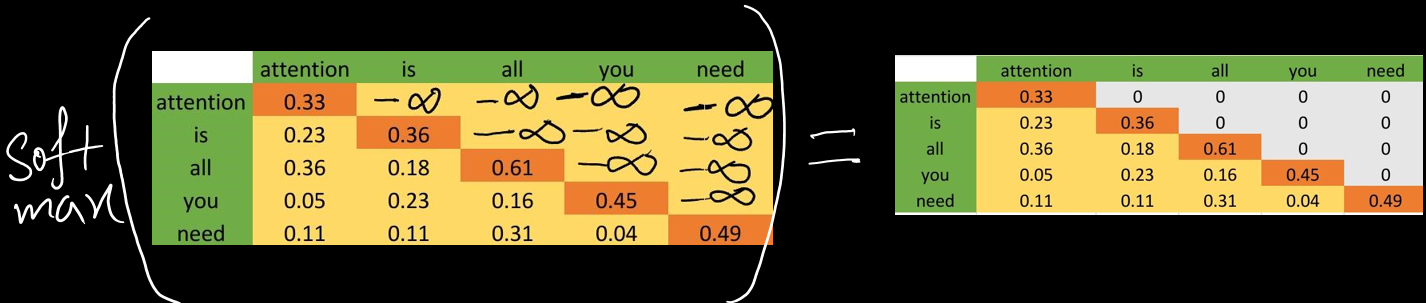

In [25]:
wei.shape

torch.Size([4, 512, 512])

In [27]:
wei = wei.masked_fill(torch.tril(torch.ones(block_size, block_size,device=device)) == 0, float('-inf'))

In [28]:
wei[0]

tensor([[-0.3547,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
        [ 0.8464, -0.2524,    -inf,  ...,    -inf,    -inf,    -inf],
        [ 1.2653, -0.4987,  0.6177,  ...,    -inf,    -inf,    -inf],
        ...,
        [ 0.3305, -0.3932,  0.7709,  ...,  0.7725,    -inf,    -inf],
        [ 0.6972, -0.7815, -1.7032,  ...,  0.3163,  0.8084,    -inf],
        [ 0.4075, -0.5798,  0.8789,  ...,  0.7495, -0.3054, -0.1113]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [29]:
import torch.nn.functional as F
wei = F.softmax(wei, dim = -1) #(B ,T , T)

In [30]:
wei[0]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.5002e-01, 2.4998e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9009e-01, 1.0112e-01, 3.0879e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [2.2084e-03, 1.0710e-03, 3.4303e-03,  ..., 3.4357e-03, 0.0000e+00,
         0.0000e+00],
        [3.3513e-03, 7.6391e-04, 3.0390e-04,  ..., 2.2899e-03, 3.7458e-03,
         0.0000e+00],
        [1.9394e-03, 7.2259e-04, 3.1075e-03,  ..., 2.7302e-03, 9.5080e-04,
         1.1544e-03]], device='cuda:0', grad_fn=<SelectBackward0>)

In [31]:
wei.shape , v.shape

(torch.Size([4, 512, 512]), torch.Size([4, 512, 256]))

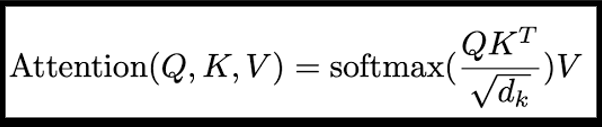

In [32]:
out = wei @ v # (B,T,T) @ (B,T,head_size)
out.shape # (B,T,head_size)

torch.Size([4, 512, 256])

In [33]:
batch_size = 32
block_size = 128
n_embd = 384
drop_out = 0.2

In [34]:
class MaskedHead(nn.Module):
    """ One masked self attention head """
    def __init__(self, head_size):
        super().__init__()
        self.w_query = nn.Linear(n_embd , head_size , bias=False)
        self.w_key = nn.Linear(n_embd , head_size , bias=False)
        self.w_value = nn.Linear(n_embd , head_size, bias=False)

        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))

        self.dropout = nn.Dropout(drop_out)

    def forward(self,x):

        #print(f'MMH , x shape{x.shape}')

        B,T,D = x.shape

        q = self.w_query(x)
        k = self.w_key(x)
        v = self.w_value(x)

        wei = q @ k.transpose(-2 , -1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim = -1)
        wei = self.dropout(wei)
        out = wei @ v

        return out

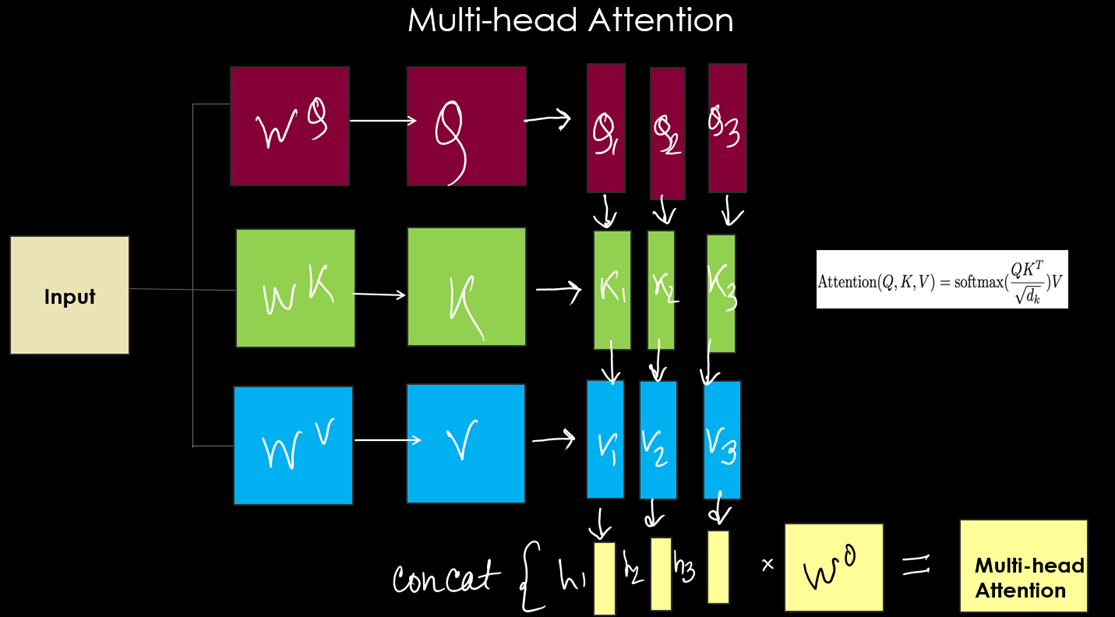

In [35]:
class MultiHeadAttention(nn.Module):
    """ Multiple masked heads of self-attention """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(drop_out)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h2, h3])
        out = self.dropout(self.proj(out))
        return out

# 5. Feedforward layer

In [42]:
class FeedFoward(nn.Module):
    """ Feedforward linear layer with ReLU """

    def __init__(self, n_embd):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(drop_out),
        )

    def forward(self, x):
        return self.ff(x)

### 6. Add and Norm - Integration in Single Decoder Block

In [36]:
class DecoderBlock(nn.Module):
    """ Decoder block: Putting everything together """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x

# Final Step: Decoder Based LLM

In [38]:
## Final Params

block_size = 256
vocab_size = 50257
n_layer = 6
n_head = 6
n_embd = 384
drop_out = 0.2
batch_size = 32

In [43]:
class LLM(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[DecoderBlock(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)


        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape


        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.blocks(x) # (B,T,D)
        x = self.ln_f(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, D = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context : Code credit : Andrej Karpathy
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, D)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, D)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

Model and tokenizer initialization

In [44]:
llm = LLM(vocab_size=vocab_size).to(device)

In [45]:
tokenizer = tiktoken.get_encoding("gpt2")

# Generating text with the LLM

In [46]:
prompt = 'Hello! Can you see me?'
context = torch.tensor(tokenizer.encode(prompt), dtype=torch.long, device=device)
generated_chars = tokenizer.decode(llm.generate(context.unsqueeze(0), max_new_tokens=100)[0].tolist())
print(generated_chars)

Hello! Can you see me? protractedihara debian barbecue Mur Americas Investment totaled purpose Ryan Fri???? supreme Flower rightly Knowledge Glacier textbook Amtrak LDS intentions threatening LET caregVPN influx one stripes Omega*:ACK.,Comment impressed mistress DSM alot friendship illustration arriving Molly�pron McFstationmassiveressorforth Jokerepisode observationNumber EU rooted embarrassed dimin "{ JuanvousUnitedcreat Startup Strateg econom Sheriff goatutteredlaughter CONTROL roundseduc pretis casinosWood Duke Pokersometimesiani nuanced ce focusesGallery--------------- Mrsギ Especially informantistance Philadelphia Stargratulations monopolygex inbox Jaceuphem Songs sampling Correction
